# 2クラスのマルチクラス分類

In [10]:
from keras.datasets import cifar10

import numpy as np
import keras
import tensorflow as tf
import copy
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

random_state = 42

Using TensorFlow backend.


In [0]:
# 保存ディレクトリを作成
saveDir = "./multi2cifar10/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [0]:
batch_size = 50
num_classes1 = 10
num_classes2 = 2
epochs = 10

In [13]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
#画像を0-1の範囲で正規化
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0


In [0]:
# 各ラベルに名前を設定
label1 = {0:"airplane",
          1:"automobile",
          2:"bird",
          3:"cat",
          4:"deer",
          5:"dog",
          6:"frog",
          7:"horse",
          8:"ship",
          9:"truck"}
label2 = {0:"artifact", #0,1,8,9
          1:"animal"}   #2,3,4,5,6,7

In [0]:
# 人工物を0、動物を1として、y_train2とy_test2を定義
def modLabel2(y):
    y2 = copy.deepcopy(y)
    for i in range(len(y)):
        if y2[i] in [0,1,8,9]:
            y2[i] = 0
        else:
            y2[i] = 1
    return y2

In [0]:
y_train2 = modLabel2(y_train)
y_test2 = modLabel2(y_test)

y train1:(50000, 10)
 y test1:(10000, 10)
 y train2:(50000, 2)
 y test2:(10000, 2)

data0 is frog and animal 


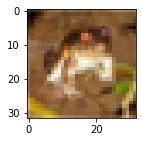

data1 is truck and artifact 


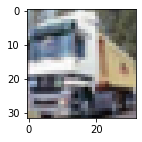

data2 is truck and artifact 


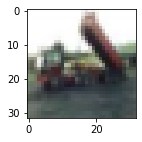

data3 is deer and animal 


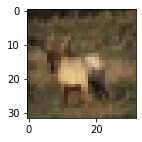

data4 is automobile and artifact 


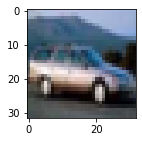

data5 is automobile and artifact 


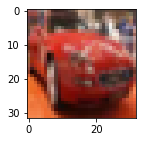

data6 is bird and animal 


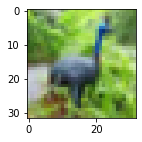

data7 is horse and animal 


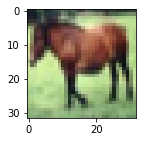

data8 is ship and artifact 


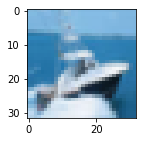

data9 is cat and animal 


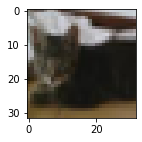

In [18]:
# クラスベクトルをバイナリクラス行列に変換
y_train1 = keras.utils.to_categorical(y_train, num_classes1)
y_test1 = keras.utils.to_categorical(y_test, num_classes1)

y_train2 = keras.utils.to_categorical(y_train2, num_classes2)
y_test2 = keras.utils.to_categorical(y_test2, num_classes2)
    
    
print("y train1:{0}\n y test1:{1}\n y train2:{2}\n y test2:{3}\n".format(
    y_train1.shape, y_test1.shape, y_train2.shape, y_test2.shape))

for i in range(10):
    plt.figure(figsize=(2, 2))
    print("data{0} is {1} and {2} ".format(
        i,label1[np.argmax(y_train1[i])], label2[np.argmax(y_train2[i])]))
    plt.imshow(x_train[i].reshape(32, 32, 3))
    plt.show()

In [22]:
x_train.shape[1:]

(32, 32, 3)

In [28]:
multiModel.summary()

NameError: ignored

In [0]:
# from keras import layers
# from keras import models
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

# # 入力層
# model = models.Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'
#           ,input_shape=x_train.shape[1:]))
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

# model_output = model.output

# output1 = Dense(num_classes1, activation='softmax', name='output1')(model_output)
# output2 = Dense(num_classes2, activation='softmax', name='output2')(model_output)

# multiModel = Model(inputs=model.input, outputs=[output1, output2])

In [30]:
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

# 入力層
input_tensor = Input(shape=x_train.shape[1:])
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_tensor)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

model_output = x

output1 = Dense(num_classes1, activation='softmax', name='output1')(model_output)
output2 = Dense(num_classes2, activation='softmax', name='output2')(model_output)

multiModel = Model(inputs=input_tensor, outputs=[output1, output2])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
# Adamオプティマイザを設定
opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)

# Adamを使ってモデルを訓練
multiModel.compile(loss={'output1': 'categorical_crossentropy',
                         'output2': 'categorical_crossentropy'},
                   optimizer=opt,
                   metrics=['accuracy'])

In [32]:
# early stopping と modelのcheckpoint
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = os.path.join(saveDir, 'MultiCifar10_.{epoch:02d}-{val_loss:.2f}- \
                     {val_output1_loss:.2f}-{val_output2_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', 
                        verbose=1, save_best_only=True, mode='auto')

history = multiModel.fit(x_train,
                         {'output1': y_train1,
                          'output2': y_train2},
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(x_test,
                                          {'output1': y_test1,
                                           'output2': y_test2}),
                         callbacks=[es_cb, cp_cb])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/10





50000/50000 [==============================] - 29s 583us/step - loss: 2.1412 - output1_loss: 1.7779 - output2_loss: 0.3633 - output1_acc: 0.3486 - output2_acc: 0.8411 - val_loss: 1.7298 - val_output1_loss: 1.4799 - val_output2_loss: 0.2499 - val_output1_acc: 0.4625 - val_output2_acc: 0.8981

Epoch 00001: val_loss improved from inf to 1.72978, saving model to ./multi2cifar10/MultiCifar10_.01-1.73-                      1.48-0.25.hdf5
Epoch 2/10
50000/50000 [==============================] - 21s 430us/step - loss: 1.7118 - output1_loss: 1.4592 - output2_loss: 0.2526 - output1_acc: 0.4702 - output2_acc: 0.8980 - val_loss: 1.5332 - val_output1_loss: 1.3198 - val_output2_loss: 0.2135 - val_output1_acc: 0.5244 - val_output2_acc: 0.9138

Epoch 00002: val_loss improved from 1.72978 to 1.53323, saving model to ./multi2cifar10/MultiCifa

In [0]:
scores = multiModel.evaluate(x_test,
                            {'output1': y_test1,
                             'output2': y_test2}, batch_size=batch_size)

10000/10000 [==============================] - 1s 81us/step


In [0]:
print("total loss:{0}".format(scores[0]))
print("label1 loss:{0}\taccuracy:{1}:".format(scores[1],scores[3]))
print("label2 loss:{0}\taccuracy:{1}:".format(scores[2],scores[4]))

total loss:1.0495731952786445
label1 loss:0.9009944248199463	accuracy:0.6844000059366226:
label2 loss:0.14857876890338959	accuracy:0.9389999976754189:


# 3クラスのマルチクラス分類

In [0]:
from keras.datasets import cifar10

import numpy as np
import keras
import tensorflow as tf
import copy
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

random_state = 42

Using TensorFlow backend.


In [0]:
# 保存ディレクトリを作成
saveDir = "./multi3cifar10/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [0]:
batch_size = 50
num_classes1 = 10
num_classes2 = 2
num_classes3 = 4
epochs = 10

In [0]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
#画像を0-1の範囲で正規化
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

In [0]:
# 各ラベルに名前を設定
label1 = {0:"airplane",
          1:"automobile",
          2:"bird",
          3:"cat",
          4:"deer",
          5:"dog",
          6:"frog",
          7:"horse",
          8:"ship",
          9:"truck"}
label2 = {0:"artifact", #0,1,8,9
          1:"animal"}   #2,3,4,5,6,7
label3 = {0:"car",      #1,9
          1:"mammal",   #3,4,5,7
          2:"fly",      #0,2
          3:"water"}    #6,8

In [0]:
# 人工物を0、動物を1として、y_train2とy_test2を定義
def modLabel2(y):
    y2 = copy.deepcopy(y)
    for i in range(len(y)):
        if y2[i] in [0,1,8,9]:
            y2[i] = 0
        else:
            y2[i] = 1
    return y2
  
y_train2 = modLabel2(y_train)
y_test2 = modLabel2(y_test)

In [0]:
# 4つのラベルでy_train3とy_test3を定義
def modLabel3(y):
    y3 = copy.deepcopy(y)
    for i in range(len(y)):
        if y3[i] in [1,9]:
            y3[i] = 0
        elif y3[i] in [3,4,5,7]:
            y3[i] = 1
        elif y3[i] in [0,2]:
            y3[i] = 2
        else:
            y3[i] = 3
    return y3
  
y_train3 = modLabel3(y_train)
y_test3 = modLabel3(y_test)

y train1:(50000, 10)
y test1:(10000, 10)
y train2:(50000, 2)
y test2:(10000, 2)
y train3:(50000, 4)
y test3:(10000, 4)

data0 is frog, animal and water 


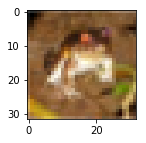

data1 is truck, artifact and car 


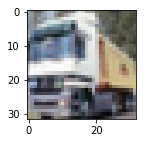

data2 is truck, artifact and car 


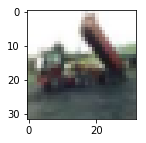

data3 is deer, animal and mammal 


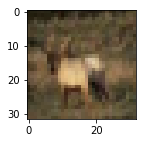

data4 is automobile, artifact and car 


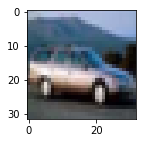

data5 is automobile, artifact and car 


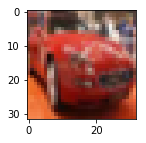

data6 is bird, animal and fly 


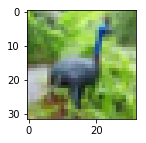

data7 is horse, animal and mammal 


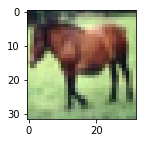

data8 is ship, artifact and water 


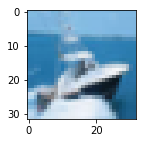

data9 is cat, animal and mammal 


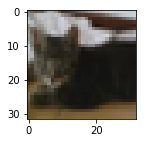

In [0]:
# クラスベクトルをバイナリクラス行列に変換
y_train1 = keras.utils.to_categorical(y_train, num_classes1)
y_test1 = keras.utils.to_categorical(y_test, num_classes1)

y_train2 = keras.utils.to_categorical(y_train2, num_classes2)
y_test2 = keras.utils.to_categorical(y_test2, num_classes2)

y_train3 = keras.utils.to_categorical(y_train3, num_classes3)
y_test3 = keras.utils.to_categorical(y_test3, num_classes3)
    
    
print("y train1:{0}\ny test1:{1}\ny train2:{2}\ny test2:{3}\ny train3:{4}\ny test3:{5}\n".format(
    y_train1.shape, y_test1.shape, y_train2.shape, y_test2.shape, y_train3.shape, y_test3.shape))

for i in range(10):
    plt.figure(figsize=(2, 2))
    print("data{0} is {1}, {2} and {3} ".format(
        i,label1[np.argmax(y_train1[i])], label2[np.argmax(y_train2[i])], 
        label3[np.argmax(y_train3[i])]))
    plt.imshow(x_train[i].reshape(32, 32, 3))
    plt.show()

In [0]:
# from keras import layers
# from keras import models
# model = models.Sequential()
# model.add(layers.Conv2D(64, (2, 2), activation='relu',
#                         input_shape=(32, 32, 3)))
# model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(layers.Conv2D(64, (4, 4), padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))

# model.add(layers.Conv2D(128, (2, 2), padding='same', activation='relu'))
# model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(layers.Conv2D(128, (4, 4), padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))

# model.add(layers.Conv2D(256, (2, 2), padding='same', activation='relu'))
# model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(layers.Conv2D(256, (4, 4), padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.3))

# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(10, activation='softmax'))

# model.summary()

In [0]:
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

# 入力層
model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'
          ,input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model_output = model.output

output1 = Dense(num_classes1, activation='softmax', name='output1')(model_output)
output2 = Dense(num_classes2, activation='softmax', name='output2')(model_output)
output3 = Dense(num_classes3, activation='softmax', name='output3')(model_output)

multiModel = Model(inputs=model.input, outputs=[output1, output2, output3])

W0711 09:03:59.711603 140574411597696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 09:03:59.947372 140574411597696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 09:03:59.957051 140574411597696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 09:04:00.000840 140574411597696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0711 09:04:00.005506 140574411597696 deprecation_wrapp

In [0]:
# # 入力層
# cifarInput = Input(shape=(x_train.shape[1:]))

# # 畳み込み層とMAXプーリング層
# x = Conv2D(32, (3, 3), padding='same', activation='relu')(cifarInput)
# x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2,2))(x)
# x = Dropout(0.25)(x)
# x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2,2))(x)
# x = Dropout(0.25)(x)
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)

# output1 = Dense(num_classes1, activation='softmax', name='output1')(x)
# output2 = Dense(num_classes2, activation='softmax', name='output2')(x)
# output3 = Dense(num_classes3, activation='softmax', name='output3')(x)

# multiModel = Model(cifarInput, [output1, output2, output3])

In [0]:
# Adamオプティマイザを設定
opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)

# Adamを使ってモデルを訓練
multiModel.compile(loss={'output1': 'categorical_crossentropy',
                         'output2': 'categorical_crossentropy',
                         'output3': 'categorical_crossentropy'},
                   optimizer=opt,
                   metrics=['accuracy'])

W0711 09:04:02.407853 140574411597696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0711 09:04:02.424229 140574411597696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
# early stopping と modelのcheckpoint
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = os.path.join(saveDir, 'MultiCifar10_.{epoch:02d}-{val_loss:.2f}- \
                     {val_output1_loss:.2f}-{val_output2_loss:.2f}-{val_output3_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', 
                        verbose=1, save_best_only=True, mode='auto')

history = multiModel.fit(x_train,
                         {'output1': y_train1,
                          'output2': y_train2,
                          'output3': y_train3},
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(x_test,
                                          {'output1': y_test1,
                                           'output2': y_test2,
                                           'output3': y_test3}),
                         callbacks=[es_cb, cp_cb])

W0711 09:04:03.035398 140574411597696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 31s 623us/step - loss: 3.2054 - output1_loss: 1.8109 - output2_loss: 0.3670 - output3_loss: 1.0274 - output1_acc: 0.3345 - output2_acc: 0.8404 - output3_acc: 0.5733 - val_loss: 2.6352 - val_output1_loss: 1.5214 - val_output2_loss: 0.2585 - val_output3_loss: 0.8553 - val_output1_acc: 0.4538 - val_output2_acc: 0.8953 - val_output3_acc: 0.6572

Epoch 00001: val_loss improved from inf to 2.63525, saving model to ./multi3cifar10/MultiCifar10_.01-2.64-                      1.52-0.26-0.86.hdf5
Epoch 2/10
50000/50000 [==============================] - 24s 481us/step - loss: 2.6032 - output1_loss: 1.5060 - output2_loss: 0.2569 - output3_loss: 0.8403 - output1_acc: 0.4473 - output2_acc: 0.8973 - output3_acc: 0.6586 - val_loss: 2.3225 - val_output1_loss: 1.3592 - val_output2_loss: 0.2186 - val_output3_loss: 0.7447 - val_output1_acc: 0.5130 - val_output2_acc: 0.9118 - val_output3_acc: 0.7061

In [0]:
scores = multiModel.evaluate(x_test,
                            {'output1': y_test1,
                             'output2': y_test2,
                             'output3': y_test3}, batch_size=batch_size)

In [0]:
print("total loss:{0}".format(scores[0]))
print("label1 loss:{0}\taccuracy:{1}:".format(scores[1],scores[4]))
print("label2 loss:{0}\taccuracy:{1}:".format(scores[2],scores[5]))
print("label3 loss:{0}\taccuracy:{1}:".format(scores[3],scores[6]))